In [13]:
from preprocessing import *
import pandas as pd
import cv2
import seaborn as sns
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle

### Load Image Paths and Meta Data
To make our lives easier lets make a dataframe that documents all the image paths, their classes, and parses the meta-data inside the file names. This dataframe can then be used to understand class balance and to down-sample majority classes into our final working data set so we are all working off a consistent source.

In [14]:
# change this to the local directory where you downloaded the images. Too big to save in git (15 gb)
images_path = '/Users/michaelchristenson/Downloads/FireRisk'
image_df = image_dataframe(images_path)
image_df.head(5)

,image_number,class_number,latitude,longitude,file_name,class,split,full_path
0,37116641,5,-88.738664,42.705529,37116641_6_-88.7386638674395_42.7055285419354.png,Non-burnable,val,/Users/michaelchristenson/Downloads/FireRisk/v...
1,37087491,5,-83.649576,42.325344,37087491_6_-83.6495755800124_42.3253442141699.png,Non-burnable,val,/Users/michaelchristenson/Downloads/FireRisk/v...
2,36918641,5,-83.465025,42.334339,36918641_6_-83.4650249213986_42.3343394446072.png,Non-burnable,val,/Users/michaelchristenson/Downloads/FireRisk/v...
3,36530341,5,-95.896782,42.999401,36530341_6_-95.8967821287071_42.9994006791073.png,Non-burnable,val,/Users/michaelchristenson/Downloads/FireRisk/v...
4,36712831,5,-103.416799,42.759769,36712831_6_-103.416799496364_42.7597694632125.png,Non-burnable,val,/Users/michaelchristenson/Downloads/FireRisk/v...


,class,image_number
5,Very_Low,30205
3,Non-burnable,23050
1,Low,13304
2,Moderate,10389
0,High,7905
4,Very_High,4706
6,Water,2313


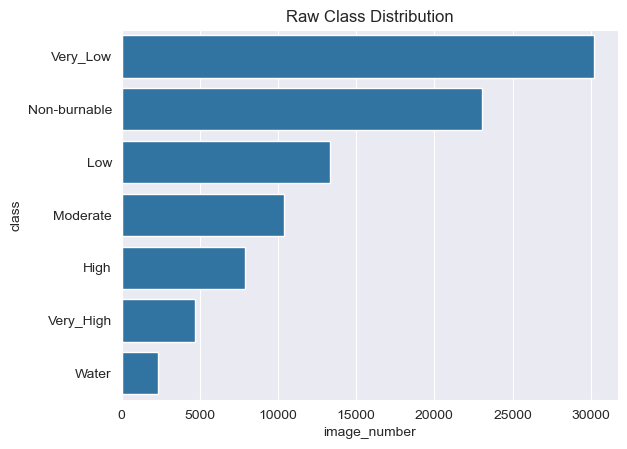

In [15]:
raw_class_counts = image_df.groupby('class', as_index=False).count().sort_values(by='image_number', ascending=False)
barplot = sns.barplot(data=raw_class_counts, x='image_number', y='class')
barplot.set_title('Raw Class Distribution')
raw_class_counts[['class', 'image_number']]

### Down-sample Majority Classes

There is a pretty extreme imbalance in the raw data set with the vast majority of classes having little or no fire risk, and there being particularly few examples of water. As a starting point lets keep all the water images (2313) and then randomly select 2313 images from each of the other 6 classes.

,class,image_number
0,High,2313
1,Low,2313
2,Moderate,2313
3,Non-burnable,2313
4,Very_High,2313
5,Very_Low,2313
6,Water,2313


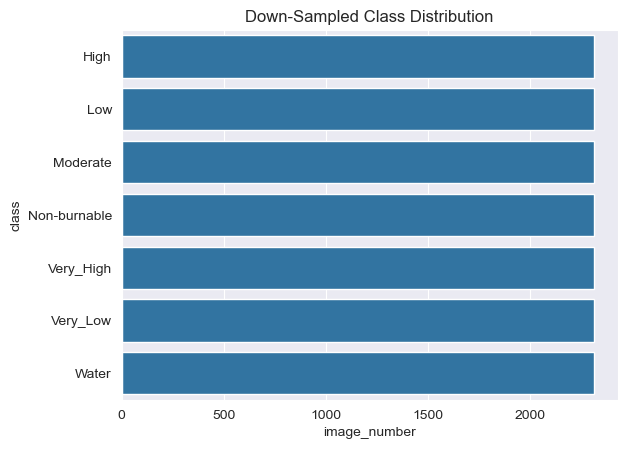

In [16]:
np.random.seed(42)  # Make sure the samples are repeatable
sample_size = 2313
sample_classes = [0, 1, 2, 3, 4, 5]
down_samples = [image_df[image_df.class_number == 6].reset_index(inplace=False, drop=True)]
for sample_class in sample_classes:
    sub_sample = image_df[image_df.class_number == sample_class].reset_index(inplace=False, drop=True)
    samples = sub_sample.sample(sample_size)
    down_samples.append(samples)
sample_df = pd.concat(down_samples).reset_index(inplace=False, drop=True)
sample_class_counts = sample_df.groupby('class', as_index=False).count().sort_values(by='image_number', ascending=False)
sample_barplot = sns.barplot(data=sample_class_counts, x='image_number', y='class')
sample_barplot.set_title('Down-Sampled Class Distribution')
sample_class_counts[['class', 'image_number']]

### Color Histograms

In [26]:
def color_hist(image_row):
    """"""
    raw_img = cv2.imread(image_row['full_path'])
    blue_hist = cv2.calcHist([raw_img], [0], None, [256], [0, 256])
    red_hist = cv2.calcHist([raw_img], [1], None, [256], [0, 256])
    green_hist = cv2.calcHist([raw_img], [2], None, [256], [0, 256])
    return [blue_hist, red_hist, green_hist]


In [24]:
def plot_color_histogram(rgb_hist):
    fig, ax = plt.subplots()
    ax.plot(rgb_hist[0], color='red')
    ax.plot(rgb_hist[1], color='green')
    ax.plot(rgb_hist[2], color='blue')
    plt.show()


In [27]:
t0 = timer()
histograms = sample_df.apply(color_hist, axis=1)
print(f'total_hist_time: {timer() - t0}')

total_hist_time: 47.94248070799995


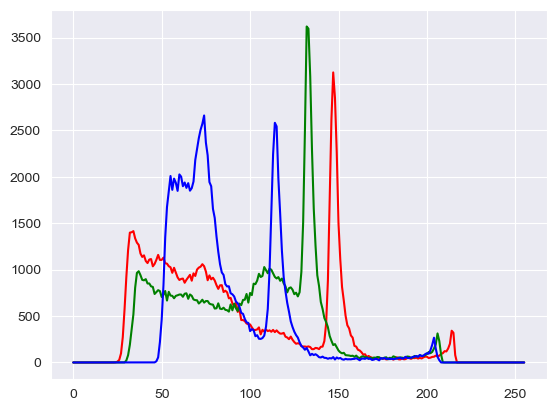

In [28]:
test_histogram = histograms[0]
plot_color_histogram(test_histogram)